In [17]:
!pip install pandas numpy scikit-learn matplotlib seaborn plotly


In [18]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

Length - 100000 & Unique Wallets 3497


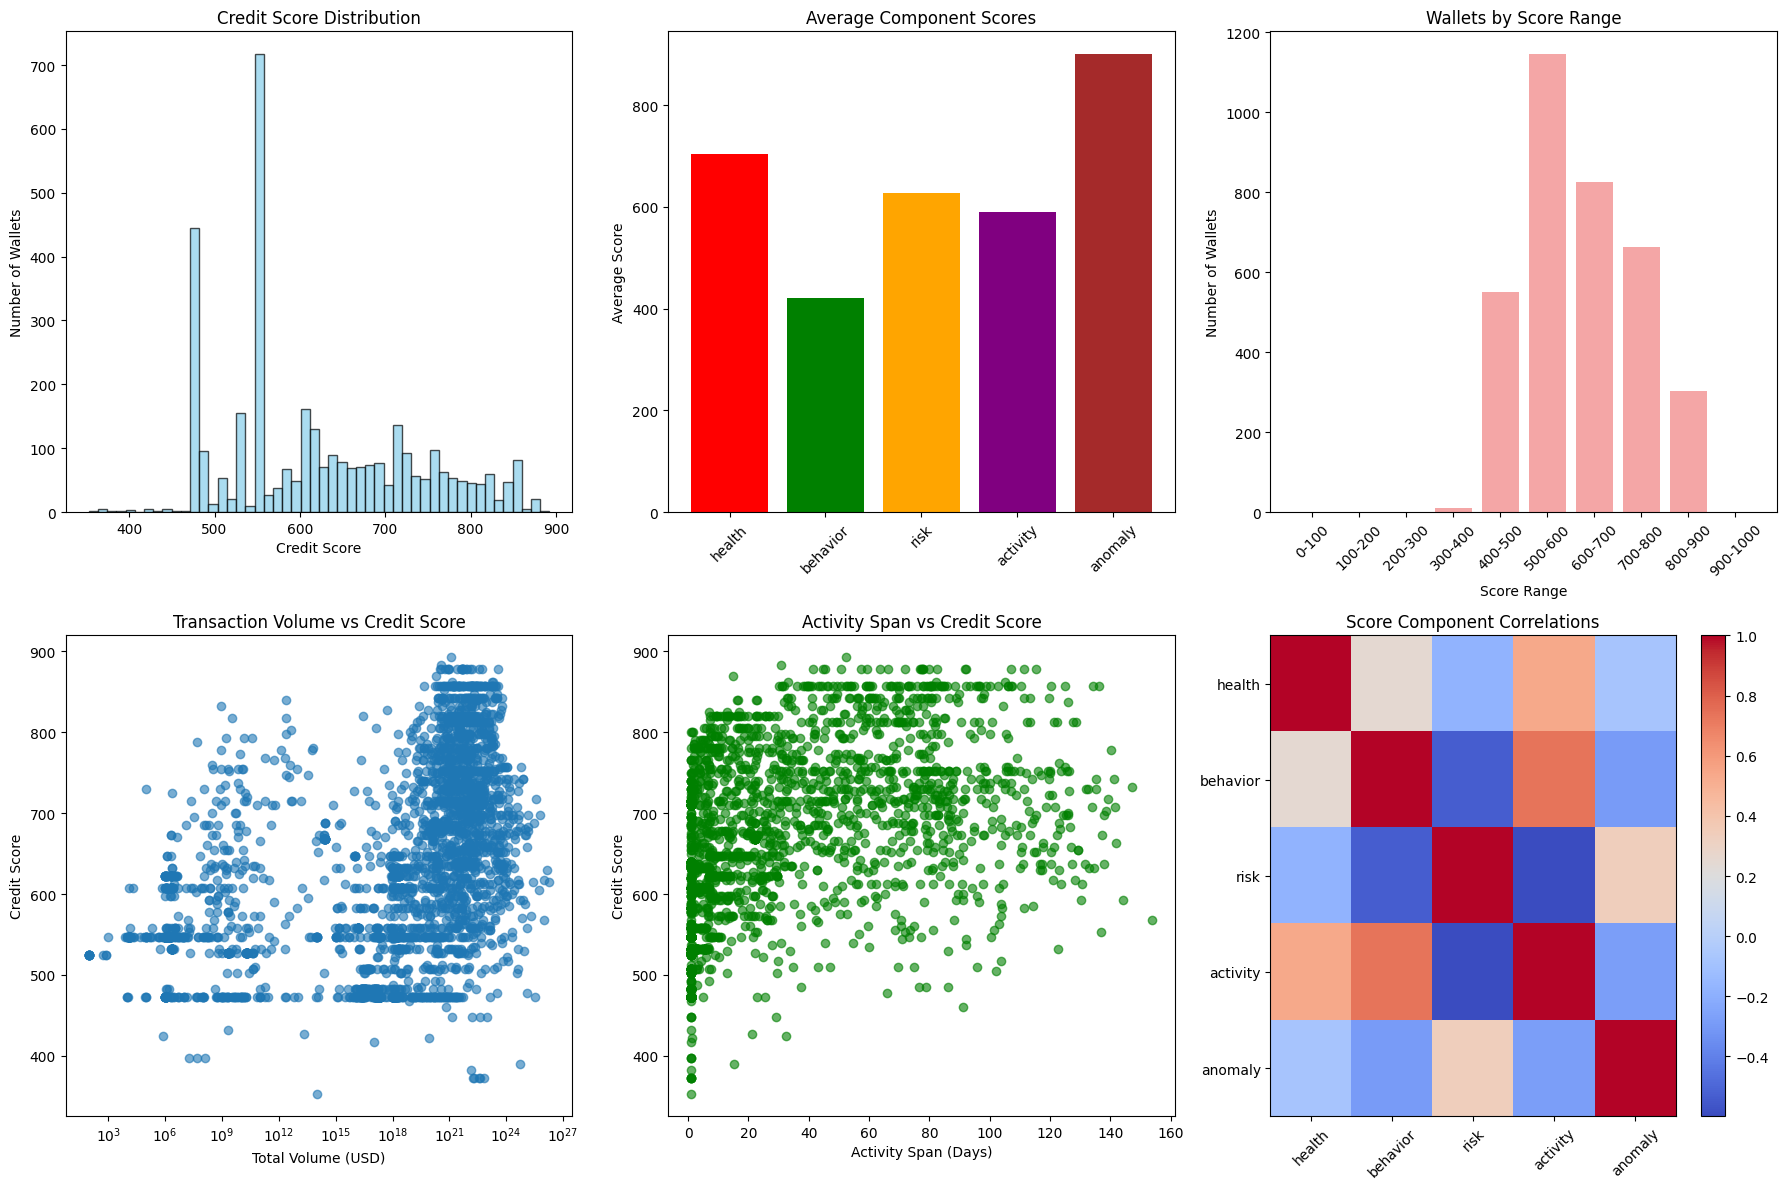


DEFI CREDIT SCORING ANALYSIS REPORT

DATASET OVERVIEW:
Total Wallets Analyzed: 3497
Average Credit Score: 620.49
Median Credit Score: 607.50
Standard Deviation: 113.46

SCORE DISTRIBUTION BY RANGE:
0-100: 0 wallets (0.0%)
100-200: 0 wallets (0.0%)
200-300: 0 wallets (0.0%)
300-400: 11 wallets (0.3%)
400-500: 551 wallets (15.8%)
500-600: 1145 wallets (32.7%)
600-700: 825 wallets (23.6%)
700-800: 662 wallets (18.9%)
800-900: 303 wallets (8.7%)
900-1000: 0 wallets (0.0%)

HIGH SCORE WALLETS (700+): 965 wallets
Average characteristics:
  - Total transactions: 41.1
  - Total volume (USD): $125048616878940369190912.00
  - Activity span: 47.7 days
  - Repay-to-borrow ratio: 0.71
  - Liquidation ratio: 0.0000

LOW SCORE WALLETS (≤300): 0 wallets


Results saved to:
- /content/drive/MyDrive/DATASETS/wallet_credit_scores.csv
- /content/drive/MyDrive/DATASETS/wallet_features.csv


In [24]:
class DeFiCreditScorer:
    def __init__(self):
        self.scaler = RobustScaler()
        self.isolation_forest = IsolationForest(contamination=0.1, random_state=42)
        self.kmeans = KMeans(n_clusters=5, random_state=42)

    def load_data(self, file_path): # Loading the data from json file
        with open(file_path, 'r') as f:
            data = json.load(f)

        df = pd.DataFrame(data)
        print(f"Length - {len(df)} & Unique Wallets {df['userWallet'].nunique()}")
        return df

    def engineer_features(self, df):  # Feature enginering
        # Convert timestamp to datetime
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
        df['amount_usd'] = df['actionData'].apply(lambda x:
            float(x.get('amount', 0)) * float(x.get('assetPriceUSD', 0)) if x.get('assetPriceUSD') else 0)

        features = []

        for wallet in df['userWallet'].unique():
            wallet_data = df[df['userWallet'] == wallet].copy()
            wallet_data = wallet_data.sort_values('timestamp')

            feature_dict = {'wallet': wallet}

            # Basic Transaction Metrics
            feature_dict['total_transactions'] = len(wallet_data)
            feature_dict['unique_assets'] = wallet_data['actionData'].apply(
                lambda x: x.get('assetSymbol', 'Unknown')).nunique()
            feature_dict['total_volume_usd'] = wallet_data['amount_usd'].sum()
            feature_dict['avg_transaction_size'] = wallet_data['amount_usd'].mean()
            feature_dict['median_transaction_size'] = wallet_data['amount_usd'].median()
            feature_dict['max_transaction_size'] = wallet_data['amount_usd'].max()

            # Action Distribution
            action_counts = wallet_data['action'].value_counts()
            for action in ['deposit', 'borrow', 'repay', 'redeemunderlying', 'liquidationcall']:
                feature_dict[f'{action}_count'] = action_counts.get(action, 0)
                feature_dict[f'{action}_ratio'] = action_counts.get(action, 0) / len(wallet_data)

            # Temporal Features
            time_span = (wallet_data['timestamp'].max() - wallet_data['timestamp'].min()) / (24 * 3600)  # days
            feature_dict['activity_span_days'] = max(time_span, 1)
            feature_dict['transactions_per_day'] = len(wallet_data) / max(time_span, 1)

            # Time gaps between transactions
            if len(wallet_data) > 1:
                time_diffs = wallet_data['timestamp'].diff().dropna() / 3600  # hours
                feature_dict['avg_time_between_tx'] = time_diffs.mean()
                feature_dict['std_time_between_tx'] = time_diffs.std()
                feature_dict['min_time_between_tx'] = time_diffs.min()
            else:
                feature_dict['avg_time_between_tx'] = 0
                feature_dict['std_time_between_tx'] = 0
                feature_dict['min_time_between_tx'] = 0

            # Financial Health Indicators
            deposits = wallet_data[wallet_data['action'] == 'deposit']['amount_usd'].sum()
            borrows = wallet_data[wallet_data['action'] == 'borrow']['amount_usd'].sum()
            repays = wallet_data[wallet_data['action'] == 'repay']['amount_usd'].sum()
            withdrawals = wallet_data[wallet_data['action'] == 'redeemunderlying']['amount_usd'].sum()
            liquidations = wallet_data[wallet_data['action'] == 'liquidationcall']['amount_usd'].sum()

            feature_dict['net_deposits'] = deposits - withdrawals
            feature_dict['net_borrows'] = borrows - repays
            feature_dict['deposit_to_borrow_ratio'] = deposits / max(borrows, 1)
            feature_dict['repay_to_borrow_ratio'] = repays / max(borrows, 1)
            feature_dict['liquidation_ratio'] = liquidations / max(deposits + borrows, 1)

            # Risk Indicators
            feature_dict['transaction_variance'] = wallet_data['amount_usd'].var()
            feature_dict['large_transaction_ratio'] = (
                wallet_data['amount_usd'] > wallet_data['amount_usd'].quantile(0.9)).mean()

            # Bot-like Behavior Detection
            feature_dict['round_number_ratio'] = self._calculate_round_number_ratio(wallet_data)
            feature_dict['repetitive_pattern_score'] = self._calculate_repetitive_pattern_score(wallet_data)

            # Asset Diversity
            asset_distribution = wallet_data['actionData'].apply(
                lambda x: x.get('assetSymbol', 'Unknown')).value_counts()
            feature_dict['asset_concentration'] = (asset_distribution / len(wallet_data)).max()
            feature_dict['gini_coefficient'] = self._calculate_gini_coefficient(asset_distribution)

            features.append(feature_dict)

        return pd.DataFrame(features)

    def _calculate_round_number_ratio(self, wallet_data):
        """Calculate ratio of round number transactions (potential bot indicator)"""
        amounts = wallet_data['actionData'].apply(lambda x: float(x.get('amount', 0)))
        if len(amounts) == 0:
            return 0

        # Checking round numbers
        round_numbers = 0
        for amount in amounts:
            if amount > 0:
                str_amount = f"{amount:.0f}"
                trailing_zeros = len(str_amount) - len(str_amount.rstrip('0'))
                if trailing_zeros >= 3:
                    round_numbers += 1

        return round_numbers / len(amounts)

    def _calculate_repetitive_pattern_score(self, wallet_data):  # Calc repetitive pattern
        if len(wallet_data) < 3:
            return 0

        amounts = wallet_data['amount_usd'].values
        actions = wallet_data['action'].values

        # Check for repeated amount patterns
        amount_repetition = len(amounts) - len(set(amounts))
        amount_score = amount_repetition / len(amounts)

        # Check for repeated action patterns
        action_patterns = []
        for i in range(len(actions) - 1):
            action_patterns.append(f"{actions[i]}_{actions[i+1]}")

        if len(action_patterns) > 0:
            pattern_repetition = len(action_patterns) - len(set(action_patterns))
            pattern_score = pattern_repetition / len(action_patterns)
        else:
            pattern_score = 0

        return (amount_score + pattern_score) / 2

    def _calculate_gini_coefficient(self, distribution):  # Calc. gini-coefficient for asset distribution
        if len(distribution) <= 1:
            return 0

        values = np.array(distribution.values)
        values = np.sort(values)
        n = len(values)
        cumsum = np.cumsum(values)

        return (n + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / n

    def calculate_credit_scores(self, features_df): # Calculating credit scores
        # Prepare features for ML models
        feature_columns = [col for col in features_df.columns if col != 'wallet']
        X = features_df[feature_columns].fillna(0)

        # Replace infinite values
        X = X.replace([np.inf, -np.inf], 0)

        # Scale features
        X_scaled = self.scaler.fit_transform(X)

        # For Anomaly Detection Score (using Isolation Forest)
        anomaly_scores = self.isolation_forest.fit_predict(X_scaled)
        anomaly_scores = (anomaly_scores + 1) / 2  # Convert -1,1 to 0,1

        # For Financial Health Score
        health_scores = self._calculate_health_scores(features_df)

        # For Behavioral Consistency Score
        behavior_scores = self._calculate_behavior_scores(features_df)

        # For Risk Assessment Score
        risk_scores = self._calculate_risk_scores(features_df)

        # For Activity Quality Score
        activity_scores = self._calculate_activity_scores(features_df)

        # Combine scores with weights
        weights = {
            'health': 0.3,
            'behavior': 0.25,
            'risk': 0.2,
            'activity': 0.15,
            'anomaly': 0.1
        }

        combined_scores = (
            weights['health'] * health_scores +
            weights['behavior'] * behavior_scores +
            weights['risk'] * risk_scores +
            weights['activity'] * activity_scores +
            weights['anomaly'] * anomaly_scores
        )

        # Scale to 0-1000
        final_scores = np.clip(combined_scores * 1000, 0, 1000)

        # Create results dataframe
        results_df = features_df[['wallet']].copy()
        results_df['health_score'] = health_scores * 1000
        results_df['behavior_score'] = behavior_scores * 1000
        results_df['risk_score'] = risk_scores * 1000
        results_df['activity_score'] = activity_scores * 1000
        results_df['anomaly_score'] = anomaly_scores * 1000
        results_df['final_credit_score'] = final_scores

        return results_df

    def _calculate_health_scores(self, features_df):
        """Calculate financial health scores"""
        scores = []

        for _, row in features_df.iterrows():
            score = 0.5  # Base score

            # Positive indicators
            if row['repay_to_borrow_ratio'] > 0.8:  # Good repayment ratio
                score += 0.2
            if row['deposit_to_borrow_ratio'] > 1.5:  # More deposits than borrows
                score += 0.15
            if row['net_deposits'] > 0:  # Positive net deposits
                score += 0.1
            if row['liquidation_ratio'] < 0.05:  # Low liquidation ratio
                score += 0.1

            # Negative indicators
            if row['liquidation_ratio'] > 0.2:  # High liquidation ratio
                score -= 0.3
            if row['repay_to_borrow_ratio'] < 0.3:  # Poor repayment
                score -= 0.2
            if row['net_borrows'] > row['total_volume_usd'] * 0.8:  # Excessive borrowing
                score -= 0.15

            scores.append(np.clip(score, 0, 1))

        return np.array(scores)

    def _calculate_behavior_scores(self, features_df):
        """Calculate behavioral consistency scores"""
        scores = []

        for _, row in features_df.iterrows():
            score = 0.5  # Base score

            # Positive indicators
            if row['activity_span_days'] > 30:  # Long-term user
                score += 0.15
            if row['unique_assets'] > 2:  # Diversified portfolio
                score += 0.1
            if row['asset_concentration'] < 0.7:  # Not overly concentrated
                score += 0.1
            if row['std_time_between_tx'] > 24:  # Not too frequent (human-like)
                score += 0.1

            # Negative indicators (bot-like behavior)
            if row['round_number_ratio'] > 0.8:  # Too many round numbers
                score -= 0.3
            if row['repetitive_pattern_score'] > 0.7:  # Too repetitive
                score -= 0.25
            if row['min_time_between_tx'] < 0.1:  # Very fast transactions
                score -= 0.2
            if row['transactions_per_day'] > 50:  # Too many transactions per day
                score -= 0.15

            scores.append(np.clip(score, 0, 1))

        return np.array(scores)

    def _calculate_risk_scores(self, features_df):
        """Calculate risk assessment scores"""
        scores = []

        for _, row in features_df.iterrows():
            score = 0.5  # Base score

            # Low risk indicators
            if row['transaction_variance'] < np.percentile(features_df['transaction_variance'], 25):
                score += 0.15
            if row['large_transaction_ratio'] < 0.1:
                score += 0.1
            if row['gini_coefficient'] < 0.5:  # Well distributed
                score += 0.1

            # High risk indicators
            if row['transaction_variance'] > np.percentile(features_df['transaction_variance'], 90):
                score -= 0.2
            if row['large_transaction_ratio'] > 0.5:
                score -= 0.15
            if row['liquidationcall_count'] > 0:  # Any liquidations
                score -= 0.2

            scores.append(np.clip(score, 0, 1))

        return np.array(scores)

    def _calculate_activity_scores(self, features_df):
        """Calculate activity quality scores"""
        scores = []

        for _, row in features_df.iterrows():
            score = 0.3  # Base score

            # Positive activity indicators
            if row['total_transactions'] >= 5:  # Sufficient activity
                score += 0.2
            if row['total_volume_usd'] > 1000:  # Significant volume
                score += 0.15
            if row['deposit_count'] > 0 and row['repay_count'] > 0:  # Diverse actions
                score += 0.15
            if 10 <= row['total_transactions'] <= 100:  # Moderate activity
                score += 0.1
            if row['activity_span_days'] > 7:  # Multi-day activity
                score += 0.1

            # Negative activity indicators
            if row['total_transactions'] < 2:  # Too little activity
                score -= 0.2
            if row['total_volume_usd'] < 10:  # Very low volume
                score -= 0.15

            scores.append(np.clip(score, 0, 1))

        return np.array(scores)

    def analyze_results(self, results_df): # Visualizing scores

        # Score distribution analysis
        score_ranges = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500),
                       (500, 600), (600, 700), (700, 800), (800, 900), (900, 1000)]

        range_analysis = {}
        for min_score, max_score in score_ranges:
            mask = (results_df['final_credit_score'] >= min_score) & (results_df['final_credit_score'] < max_score)
            range_wallets = results_df[mask]

            range_analysis[f"{min_score}-{max_score}"] = {
                'count': len(range_wallets),
                'percentage': len(range_wallets) / len(results_df) * 100,
                'avg_health': range_wallets['health_score'].mean(),
                'avg_behavior': range_wallets['behavior_score'].mean(),
                'avg_risk': range_wallets['risk_score'].mean(),
                'avg_activity': range_wallets['activity_score'].mean()
            }

        return range_analysis

    def create_visualizations(self, results_df, features_df):
        """Create comprehensive visualizations"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # 1. Score distribution histogram
        axes[0, 0].hist(results_df['final_credit_score'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 0].set_title('Credit Score Distribution')
        axes[0, 0].set_xlabel('Credit Score')
        axes[0, 0].set_ylabel('Number of Wallets')

        # 2. Score components comparison
        score_components = ['health_score', 'behavior_score', 'risk_score', 'activity_score', 'anomaly_score']
        component_means = [results_df[comp].mean() for comp in score_components]
        axes[0, 1].bar(range(len(score_components)), component_means, color=['red', 'green', 'orange', 'purple', 'brown'])
        axes[0, 1].set_title('Average Component Scores')
        axes[0, 1].set_xticks(range(len(score_components)))
        axes[0, 1].set_xticklabels([comp.replace('_score', '') for comp in score_components], rotation=45)
        axes[0, 1].set_ylabel('Average Score')

        # 3. Score ranges distribution
        ranges = ['0-100', '100-200', '200-300', '300-400', '400-500',
                 '500-600', '600-700', '700-800', '800-900', '900-1000']
        range_counts = []
        for i, (min_val, max_val) in enumerate([(i*100, (i+1)*100) for i in range(10)]):
            count = len(results_df[(results_df['final_credit_score'] >= min_val) &
                                  (results_df['final_credit_score'] < max_val)])
            range_counts.append(count)

        axes[0, 2].bar(ranges, range_counts, color='lightcoral', alpha=0.7)
        axes[0, 2].set_title('Wallets by Score Range')
        axes[0, 2].set_xlabel('Score Range')
        axes[0, 2].set_ylabel('Number of Wallets')
        axes[0, 2].tick_params(axis='x', rotation=45)

        # 4. Transaction volume vs credit score
        merged_df = results_df.merge(features_df[['wallet', 'total_volume_usd']], on='wallet')
        axes[1, 0].scatter(merged_df['total_volume_usd'], merged_df['final_credit_score'], alpha=0.6)
        axes[1, 0].set_title('Transaction Volume vs Credit Score')
        axes[1, 0].set_xlabel('Total Volume (USD)')
        axes[1, 0].set_ylabel('Credit Score')
        axes[1, 0].set_xscale('log')

        # 5. Activity span vs credit score
        merged_df = results_df.merge(features_df[['wallet', 'activity_span_days']], on='wallet')
        axes[1, 1].scatter(merged_df['activity_span_days'], merged_df['final_credit_score'], alpha=0.6, color='green')
        axes[1, 1].set_title('Activity Span vs Credit Score')
        axes[1, 1].set_xlabel('Activity Span (Days)')
        axes[1, 1].set_ylabel('Credit Score')

        # 6. Component correlation heatmap
        correlation_matrix = results_df[score_components].corr()
        im = axes[1, 2].imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
        axes[1, 2].set_title('Score Component Correlations')
        axes[1, 2].set_xticks(range(len(score_components)))
        axes[1, 2].set_yticks(range(len(score_components)))
        axes[1, 2].set_xticklabels([comp.replace('_score', '') for comp in score_components], rotation=45)
        axes[1, 2].set_yticklabels([comp.replace('_score', '') for comp in score_components])

        # Add colorbar
        plt.colorbar(im, ax=axes[1, 2])

        plt.tight_layout()
        fig.savefig('/content/drive/MyDrive/DATASETS/credit_score_visualizations.png', dpi=300)
        plt.show()

        return fig

    def generate_wallet_analysis_report(self, results_df, features_df, range_analysis): # Detailed report
        print("\n" + "="*80)
        print("DEFI CREDIT SCORING ANALYSIS REPORT")
        print("="*80)

        print(f"\nDATASET OVERVIEW:")
        print(f"Total Wallets Analyzed: {len(results_df)}")
        print(f"Average Credit Score: {results_df['final_credit_score'].mean():.2f}")
        print(f"Median Credit Score: {results_df['final_credit_score'].median():.2f}")
        print(f"Standard Deviation: {results_df['final_credit_score'].std():.2f}")

        print(f"\nSCORE DISTRIBUTION BY RANGE:")
        for range_name, analysis in range_analysis.items():
            print(f"{range_name}: {analysis['count']} wallets ({analysis['percentage']:.1f}%)")

        # High score wallets analysis
        high_score_wallets = results_df[results_df['final_credit_score'] >= 700]
        print(f"\nHIGH SCORE WALLETS (700+): {len(high_score_wallets)} wallets")
        if len(high_score_wallets) > 0:
            high_score_features = features_df[features_df['wallet'].isin(high_score_wallets['wallet'])]
            print(f"Average characteristics:")
            print(f"  - Total transactions: {high_score_features['total_transactions'].mean():.1f}")
            print(f"  - Total volume (USD): ${high_score_features['total_volume_usd'].mean():.2f}")
            print(f"  - Activity span: {high_score_features['activity_span_days'].mean():.1f} days")
            print(f"  - Repay-to-borrow ratio: {high_score_features['repay_to_borrow_ratio'].mean():.2f}")
            print(f"  - Liquidation ratio: {high_score_features['liquidation_ratio'].mean():.4f}")

        # Low score wallets analysis
        low_score_wallets = results_df[results_df['final_credit_score'] <= 300]
        print(f"\nLOW SCORE WALLETS (≤300): {len(low_score_wallets)} wallets")
        if len(low_score_wallets) > 0:
            low_score_features = features_df[features_df['wallet'].isin(low_score_wallets['wallet'])]
            print(f"Average characteristics:")
            print(f"  - Total transactions: {low_score_features['total_transactions'].mean():.1f}")
            print(f"  - Total volume (USD): ${low_score_features['total_volume_usd'].mean():.2f}")
            print(f"  - Activity span: {low_score_features['activity_span_days'].mean():.1f} days")
            print(f"  - Round number ratio: {low_score_features['round_number_ratio'].mean():.2f}")
            print(f"  - Repetitive pattern score: {low_score_features['repetitive_pattern_score'].mean():.2f}")

        print("\n" + "="*80)

# Main execution function
def main():
    scorer = DeFiCreditScorer()
    file_path = '/content/drive/MyDrive/DATASETS/user-wallet-transactions.json'
    df = scorer.load_data(file_path)
    features_df = scorer.engineer_features(df)

    results_df = scorer.calculate_credit_scores(features_df)
    range_analysis = scorer.analyze_results(results_df)

    fig = scorer.create_visualizations(results_df, features_df)

    scorer.generate_wallet_analysis_report(results_df, features_df, range_analysis)

    results_df.to_csv('/content/drive/MyDrive/DATASETS/wallet_credit_scores.csv', index=False)
    features_df.to_csv('/content/drive/MyDrive/DATASETS/wallet_features.csv', index=False)

    print(f"\nResults saved to:")
    print(f"- /content/drive/MyDrive/DATASETS/wallet_credit_scores.csv")
    print(f"- /content/drive/MyDrive/DATASETS/wallet_features.csv")

    return scorer, results_df, features_df, range_analysis

if __name__ == "__main__":
    scorer, results_df, features_df, range_analysis = main()
